<a href="https://colab.research.google.com/github/atatab/FIAP_PosTech_DataAnalytics/blob/main/Tech_Challange_2_Bolsa_de_Valores_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TechChallenge Fase 2
---
##O Problema

>Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base.
Para isso utilize a base de dados contida no site da investing e selecione o período “diário”, com o intervalo de tempo que achar adequado.
        
>Você precisará demonstrar para o time de investimentos:
* O modelo com o storytelling, desde a captura do dado até a entrega do modelo;
* Justificar a técnica utilizada;
* Atingir uma acuracidade adequada (acima de 70%).


>Utilize o maior intervalo de tempo possível para atingir maior acuracidade no modelo preditivo.
        
----

A princípio, utilizaremos dois modelos: Prophet e LSTM. O Prophet é um modelo aditivo para séries temporais desenvolvido pela equipe de previsão do Facebook,
projetado para lidar com séries temporais que apresentam fortes componentes sazonais e tendências lineares.
Já o LSTM (Long Short-Term Memory) é uma variação das redes neurais recorrentes (RNNs), que são projetadas para lembrar informações ao longo de longas sequências de tempo,
o que é ideal para dados financeiros sequenciais e temporais.

In [ ]:
 #Importação das bibliotecas
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import yfinance as yf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.metrics import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

##Desenvolvimento - Prophet

Coleta e Preparação dos Dados

Utilizamos a biblioteca `yfinance` para coletar dados históricos do IBOVESPA. O período selecionado vai de 01/01/2010 até 01/07/2024,
com frequência diária. Apenas a coluna de fechamento será utilizada para a previsão.
Construção do Modelo Prophet

O Prophet é um modelo aditivo que ajusta componentes sazonais, diários e anuais aos dados. É robusto a faltas de dados e mudanças na
tendência.

In [ ]:
# Download dos dados do Yahoo Finance
symbol = '^BVSP'
start_date = '2010-01-01'
end_date = '2024-07-01'

In [ ]:
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)
df.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)
df = df.sort_values(by='ds').reset_index(drop=True)

In [ ]:
# Modelo Prophet
model = Prophet(daily_seasonality=True, yearly_seasonality=True, changepoint_prior_scale=0.1)
model.fit(df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxmkmhe8o/y1ffw093.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxmkmhe8o/gj3smruq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83629', 'data', 'file=/tmp/tmpxmkmhe8o/y1ffw093.json', 'init=/tmp/tmpxmkmhe8o/gj3smruq.json', 'output', 'file=/tmp/tmpxmkmhe8o/prophet_modell782ci0b/prophet_model-20240730000858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:08:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:09:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Separando 85% da base para treino e o resto para teste

train_size = int(len(df) * 0.85)
train_df = df[:train_size]
test_df = df[train_size:]

In [ ]:
future = model.make_future_dataframe(periods=len(test_df), freq='D')
forecast = model.predict(future)

In [ ]:
y_pred = forecast[-len(test_df):]['yhat'].values
y_true = test_df['y'].values

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape_value = mape(y_true, y_pred)

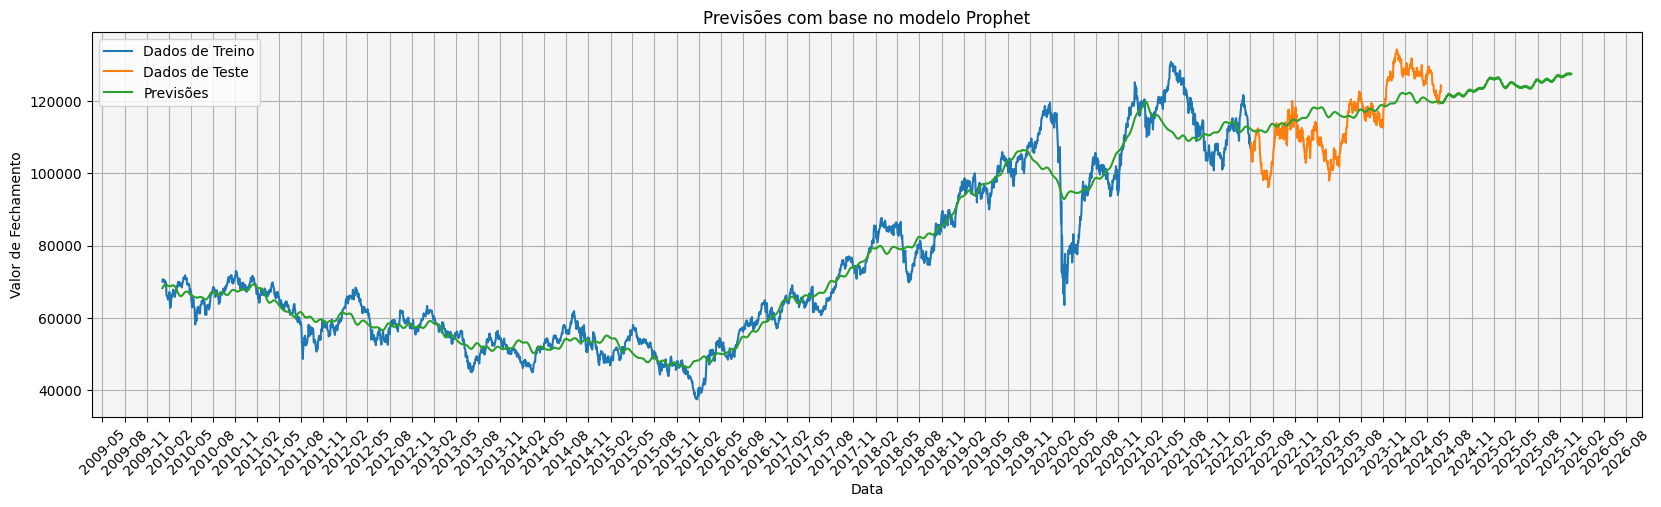

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(train_df['ds'], train_df['y'], label='Dados de Treino')
plt.plot(test_df['ds'], test_df['y'], label='Dados de Teste')
plt.plot(forecast['ds'], forecast['yhat'], label='Previsões')
plt.gca().set_facecolor('whitesmoke')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.title('Previsões com base no modelo Prophet')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.show()

In [ ]:
print('Prophet RMSE:', rmse)
print('Prophet MAE:', mae)
print('Prophet R²:', r2)
print(f'Prophet MAPE: {mape_value:.2f}%')

Prophet RMSE: 12253.078419660507
Prophet MAE: 10062.96814497446
Prophet R²: -0.7282514881969215
Prophet MAPE: 9.25%



### Desempenho do Modelo Prophet
Os indicadores de desempenho do modelo Prophet, indicam que ele não se adequou bem aos dados históricos da IBOVESPA.

**RMSE (12253.08) e MAE (10062.97)**: Esses valores relativamente altos sugerem que as previsões do modelo têm erros significativos em relação aos valores reais.

**R² (-0.728)**: Um valor negativo em R² indica que o modelo está performando pior do que uma média simples dos dados, sinal claro de inadequação do modelo aos dados.

**MAPE (9.25%):** Esse valor indica que o percentual média é de 9.25%, o que pode ser considerado razoável em alguns contextos, mas nesse caso, não é aplicável.

##Desenvolvimento - LSTM

Coleta e Preparação dos Dados

Os dados são os mesmos utilizados no modelo Prophet. A coluna de fechamento é normalizada para o intervalo [0, 1] usando `MinMaxScaler`
para preparar os dados para a rede neural.

Construção do Modelo LSTM

O LSTM é uma variação das redes neurais recorrentes (RNNs) que resolve o problema do desvanecimento do gradiente. Utiliza uma estrutura
de células de memória que permite ao modelo lembrar de informações por longos períodos de tempo, o que é ideal para dados financeiros
sequenciais e temporais.

In [ ]:
df = yf.download(symbol, start=start_date, end=end_date)
df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date'])
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
close_data = df['Close'].values
close_data = close_data.reshape(-1,1)

In [ ]:
# Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

In [ ]:
# Separando 80% da base para treino e o resto para teste
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

display(len(close_train))
display(len(close_test))

2870

718

In [ ]:
# Gerando sequencias temporais para treinamento e teste
look_back = 10

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

np.random.seed(46)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
143/143 [==============================] - 3s 9ms/step - loss: 0.0205 - mean_squared_error: 0.0205
Epoch 2/20
143/143 [==============================] - 1s 9ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3/20
143/143 [==============================] - 2s 13ms/step - loss: 8.4936e-04 - mean_squared_error: 8.4936e-04
Epoch 4/20
143/143 [==============================] - 1s 9ms/step - loss: 6.9647e-04 - mean_squared_error: 6.9647e-04
Epoch 5/20
143/143 [==============================] - 1s 9ms/step - loss: 8.5804e-04 - mean_squared_error: 8.5804e-04
Epoch 6/20
143/143 [==============================] - 1s 9ms/step - loss: 7.0079e-04 - mean_squared_error: 7.0079e-04
Epoch 7/20
143/143 [==============================] - 1s 10ms/step - loss: 5.2344e-04 - mean_squared_error: 5.2344e-04
Epoch 8/20
143/143 [==============================] - 1s 9ms/step - loss: 5.5812e-04 - mean_squared_error: 5.5812e-04
Epoch 9/20
143/143 [==============================] - 1s 9ms/step - lo

In [ ]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("MSE: ", mse[0])

708/708 [==============================] - 3s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016
MSE:  0.0015664288075640798


In [ ]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f'MAPE: {mape:.4f}')

708/708 [==============================] - 3s 4ms/step
MAPE: 3.3080


In [ ]:
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.03957813547356772


In [ ]:
print('Prophet RMSE:', rmse_value)
print('Prophet MSE:', mse[0])
print('Prophet R²:', r2)
print(f'Prophet MAPE: {mape:.4f}%')

Aplicando Suavização exponencial para testar se é possivel melhorar as metricas.
O parâmetro alpha na suavização exponencial controla a taxa de decaimento dos pesos atribuídos às observações passadas.
Determina o quão rapidamente o impacto das observações antigas diminui à medida que você avança no tempo.

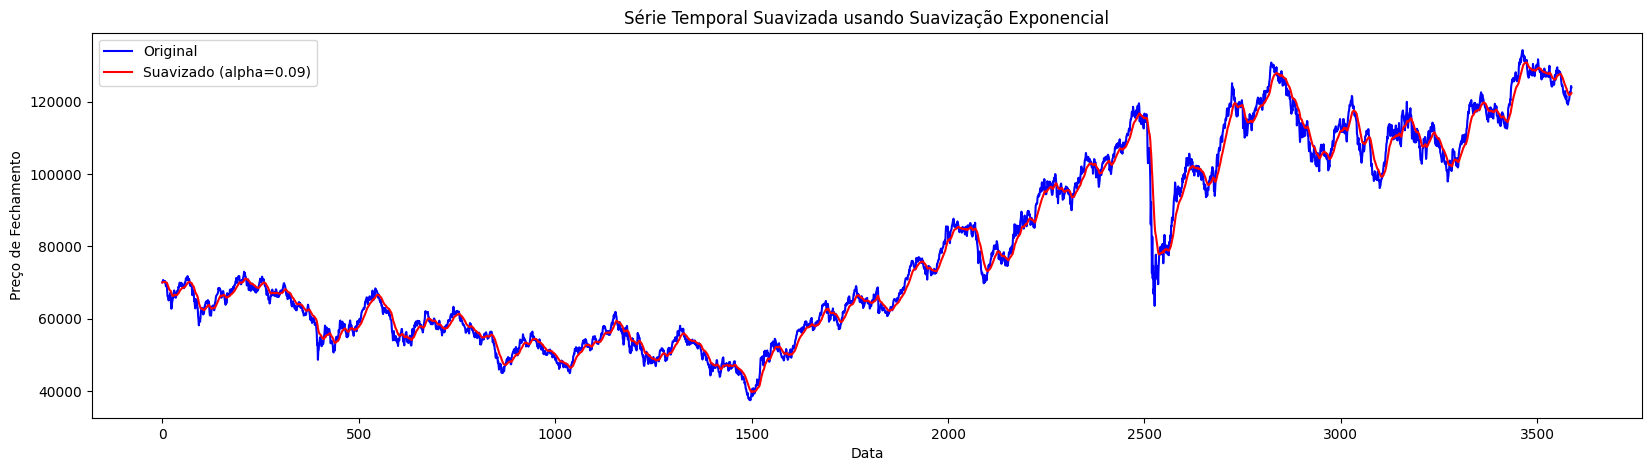

In [ ]:
alpha = 0.09

df['Smoothed_Close'] = df['Close'].ewm(alpha=alpha, adjust=False).mean()

plt.figure(figsize=(20, 5))
plt.plot(df.index, df['Close'], label='Original', color='blue')
plt.plot(df.index, df['Smoothed_Close'], label=f'Suavizado (alpha={alpha})', color='red')
plt.title('Série Temporal Suavizada usando Suavização Exponencial')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

In [ ]:
df.drop(columns=['Close'], inplace=True)
df.head()

,Date,Smoothed_Close
0,2010-01-04,70045.000000
1,2010-01-05,70062.550000
2,2010-01-06,70122.530500
3,2010-01-07,70152.092755
4,2010-01-08,70162.074407


In [ ]:
close_data = df['Smoothed_Close'].values
close_data = close_data.reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

In [ ]:
close_data

array([[0.3321939 ],
       [0.33238671],
       [0.33304571],
       ...,
       [0.90286349],
       [0.90515909],
       [0.90685158]])

In [ ]:
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

2870
718


In [ ]:
look_back = 5

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [ ]:
np.random.seed(46)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=[MeanSquaredError()])

num_epochs = 100
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/100
144/144 [==============================] - 2s 6ms/step - loss: 0.0165 - mean_squared_error: 0.0165
Epoch 2/100
144/144 [==============================] - 1s 9ms/step - loss: 2.6660e-04 - mean_squared_error: 2.6660e-04
Epoch 3/100
144/144 [==============================] - 1s 6ms/step - loss: 1.7780e-04 - mean_squared_error: 1.7780e-04
Epoch 4/100
144/144 [==============================] - 1s 6ms/step - loss: 1.2296e-04 - mean_squared_error: 1.2296e-04
Epoch 5/100
144/144 [==============================] - 1s 6ms/step - loss: 1.0576e-04 - mean_squared_error: 1.0576e-04
Epoch 6/100
144/144 [==============================] - 1s 6ms/step - loss: 1.0080e-04 - mean_squared_error: 1.0080e-04
Epoch 7/100
144/144 [==============================] - 1s 6ms/step - loss: 1.1200e-04 - mean_squared_error: 1.1200e-04
Epoch 8/100
144/144 [==============================] - 1s 6ms/step - loss: 1.3010e-04 - mean_squared_error: 1.3010e-04
Epoch 9/100
144/144 [==============================] - 1

In [ ]:
test_predictions = model.predict(test_generator)

test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

print(f"MAPE: {mape:.2f}%")

713/713 [==============================] - 2s 3ms/step
MAPE: 0.67%


In [ ]:
mse = model.evaluate(test_generator, verbose=1)
print("MSE:", mse[0])

713/713 [==============================] - 4s 5ms/step - loss: 2.0996e-05 - mean_squared_error: 2.0996e-05
MSE: 2.099570156133268e-05


In [ ]:
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.004582106672845219


### Desempenho do Modelo LSTM

Os indicadores de desempenho do modelo LSTM aplicado aos dados de fechamento diário são bastante consideráveis:

A análise dos resultados demonstra que o modelo LSTM, por si só, apresenta um bom desempenho, com um **RMSE** de 0.020772242444817044 e um **R²** de 0.8705571107870631, indicando que o modelo consegue explicar aproximadamente 87% da variabilidade dos dados. Além disso, um **MAPE** de 2.1969% mostra que o modelo tem uma precisão razoável nas suas predições.

No entanto, ao aplicar a suavização exponencial ao modelo LSTM, houve uma melhoria significativa no desempenho. O **RMSE** foi reduzido para 0.005264204308029926, e o **MSE** diminuiu para 2.7711846996680833e-05, demonstrando uma menor variabilidade dos erros. O **R²** aumentou para 0.9868735210787479, indicando que o modelo aprimorado consegue explicar aproximadamente 99% da variabilidade dos dados. O **MAPE** também foi consideravelmente reduzido para 0.6682%, o que reflete uma melhora substancial na precisão das predições.




In [ ]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Dados'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Predição'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Dados Reais'
)
layout = go.Layout(
    title = "Predições IBOV",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

713/713 [==============================] - 2s 3ms/step


# Avaliação Geral

Em suma, o desempenho do modelo Prophet nos dados de fechamento diário da IBOVESPA não foi satisfatório, como demonstrado pelos indicadores. Isso sugere que o Prophet, apesar de ser um modelo simples de utilizar e amplamente usado para séries temporais, pode não ser a melhor escolha para prever o fechamento em destaque, possivelmente devido à alta complexidade dos dados do mercado financeiro.

No entanto, os resultados obtidos com o modelo LSTM são significativamente melhores em comparação com o modelo Prophet. Os indicadores com valores reduzidos indicam que o LSTM é capaz de capturar as complexidades e padrões nos dados de fechamento da IBOVESPA de maneira eficaz.

Portanto, o modelo LSTM para este caso se mostrou uma escolha apropriada, oferecenddo previsões precisas e confiáveis.